## Notebook for plotting pareto front of KNN, KNC, & CPD for optimization runs from dimensionality reduction methods

### Data: Figure 4

**Created on 31st December, 2023; modified on February 14, 2024**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
mpl.rcParams['figure.dpi'] = 300
# mpl.rcParams['figure.figsize'] = (4, 3)
mpl.rcParams['font.size'] = 8
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['ps.fonttype'] = 42
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as py
import colorsys
import os, sys
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, TSNE
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, Normalizer
from typing import List
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Draw, PandasTools, rdMolDescriptors, Fragments
import optuna
from scipy.spatial import distance
from sklearn.neighbors import NearestNeighbors
from scipy.stats import rankdata
import scipy
from scipy.spatial.distance import pdist, squareform

from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, PandasTools, Fragments, rdMolDescriptors, Descriptors, rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.PandasTools import ChangeMoleculeRendering
import plotly.express as px
from IPython.display import SVG, display
from bokeh.plotting import figure, show, output_notebook, ColumnDataSource
from bokeh.models import HoverTool, ColorBar, CategoricalColorMapper
from bokeh.transform import factor_cmap
from bokeh.plotting import figure, output_file, save
from bokeh.transform import linear_cmap
from bokeh.palettes import Turbo256, d3
import pdb
output_notebook()

Loading BokehJS ...

In [2]:
%%bash
pwd
ls -ltr

/Users/riteshk/Library/CloudStorage/Box-Box/Research-postdoc/liquid-electrolyte-ML/Science-rev-1/red-dim-visualization/fig4-data
total 900888
-rw-------@ 1 riteshk  staff       1405 Feb 12 16:11 list+meanval_solv_multicomp_ce.csv
-rw-r--r--@ 1 riteshk  staff     205817 Feb 12 16:15 ce_ood_final_comp.csv
-rw-r--r--  1 riteshk  staff    3358410 Feb 13 00:49 fig4_data_02132024.csv
-rw-r--r--@ 1 riteshk  staff   25114089 Feb 13 00:50 gen_fig4_data.ipynb
-rw-------@ 1 riteshk  staff    5712081 Feb 13 02:43 tsne_default_openTSNE.csv
-rw-------@ 1 riteshk  staff        147 Feb 13 02:43 param_tsne_default_openTSNE.csv
-rw-------@ 1 riteshk  staff          0 Feb 13 02:43 best-paramters_tsne_all_openTSNE.txt
-rw-------@ 1 riteshk  staff    1000960 Feb 13 02:48 X_tsne_trial_0_openTSNE.npy
-rw-------@ 1 riteshk  staff    1000960 Feb 13 02:54 X_tsne_trial_1_openTSNE.npy
-rw-------@ 1 riteshk  staff    1000960 Feb 13 02:59 X_tsne_trial_2_openTSNE.npy
-rw-------@ 1 riteshk  staff    1000960 Feb 13 03

In [7]:
def find_pareto_front(data):
    """
    Find the Pareto front in a dataset with three properties.
    data: numpy array of shape (n_samples, 3)
    """
    # Initialize a boolean array to mark Pareto optimal points
    is_pareto = np.ones(data.shape[0], dtype=bool)

    for i in range(data.shape[0]):
        for j in range(data.shape[0]):
            if all(data[j] >= data[i]) and any(data[j] > data[i]):
                # Solution j dominates solution i
                is_pareto[i] = False
                break

    return data[is_pareto], np.where(is_pareto)[0]

In [4]:
def gen_color_gradient(color):
    # Convert the RGB values to HSL
    r, g, b = color
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    # Decrease the lightness value by 10%
    l -= 0.1 ## + will increase intensity
    # Convert the HSL values back to RGB
    r_, g_, b_ = colorsys.hls_to_rgb(h, l, s)
    return (r_, g_, b_)

**Pareto front for tSNE (openTSNE) trials**

In [8]:
knn_raw = !grep "values:" best-paramters_tsne_openTSNE.txt | awk '{printf "%12s\n", $9}'
knc_raw = !grep "values:" best-paramters_tsne_openTSNE.txt | awk '{printf "%12s\n", $10}'
cpd_raw = !grep "values:" best-paramters_tsne_openTSNE.txt | awk '{printf "%12s\n", $11}'

In [9]:
knn_1 = [float(k.split('[')[1].split(',')[0]) for k in knn_raw]
knc_1 = [float(k_.split(',')[0]) for k_ in knc_raw]
cpd_1 = [float(c.split(']')[0]) for c in cpd_raw]
knn_1

[0.08019088118685254,
 0.36009560046041694,
 0.21959329837575137,
 0.3967866734876583,
 0.004484269088118685,
 0.0033604041437523984,
 0.1571028903951912,
 0.2694797928123801,
 0.1334825425246195,
 0.004030246834633585,
 0.16689634224325361,
 0.06927356439442384,
 0.0091268064969945,
 0.18691328814426397,
 0.07349725028776058,
 0.12542684486507225,
 0.12045178411561581,
 0.08661273820181609,
 0.3206436245044123,
 0.005977426780918276,
 0.10044283156413865,
 0.17368749200665046,
 0.003908747921729122,
 0.10471767489448777,
 0.3984636782197212,
 0.2085033252334058]

In [10]:
tsne_opentsne = np.array([knn_1, knc_1, cpd_1]).T
tsne_opentsne.shape

(26, 3)

In [8]:
df_tsne_opentsne = pd.DataFrame(tsne_opentsne, columns=['knn', 'knc', 'cpd'])
df_tsne_opentsne.to_csv('df_metric_tsne_opentsne.csv', index=False)

In [5]:
df_tsne_opentsne = pd.read_csv('df_metric_tsne_opentsne.csv')
df_tsne_opentsne

knn       knc       cpd
0   0.080191  0.916667  0.331418
1   0.360096  0.916667  0.211548
2   0.219593  0.916667  0.356888
3   0.396787  0.916667  0.329475
4   0.004484  0.958333 -0.005411
5   0.003360  0.958333  0.033459
6   0.157103  0.958333  0.276700
7   0.269480  0.958333  0.255925
8   0.133483  0.875000  0.338592
9   0.004030  0.958333  0.027723
10  0.166896  0.958333  0.238503
11  0.069274  0.875000  0.394248
12  0.009127  0.791667  0.042453
13  0.186913  0.916667  0.311978
14  0.073497  0.875000  0.383386
15  0.125427  0.916667  0.337928
16  0.120452  0.916667  0.337492
17  0.086613  0.875000  0.360746
18  0.320644  0.875000  0.325317
19  0.005977  0.750000  0.013893
20  0.100443  0.916667  0.335348
21  0.173687  0.916667  0.346338
22  0.003909  0.750000  0.105915
23  0.104718  0.916667  0.343337
24  0.398464  0.916667  0.325723
25  0.208503  0.875000  0.330019

In [11]:
pareto_front_tsne_open, indices_tsne_open_tsne = find_pareto_front(tsne_opentsne)
pareto_front_tsne_open

array([[0.2195933 , 0.91666667, 0.3568877 ],
       [0.39678667, 0.91666667, 0.32947543],
       [0.15710289, 0.95833333, 0.27669957],
       [0.26947979, 0.95833333, 0.2559252 ],
       [0.06927356, 0.875     , 0.39424759],
       [0.07349725, 0.875     , 0.38338572],
       [0.08661274, 0.875     , 0.36074633],
       [0.39846368, 0.91666667, 0.32572347]])

In [12]:
## 3D plot with pareto front
color_tsne = (0.298, 0.78, 0.77)  # RGB values
color_tsne_pareto = (0, 0.576, 0.902)
# color_tsne = gen_color_gradient(color_tsne_pareto)
color_tsne_ = 'rgb' + str(tuple(int(255 * x) for x in color_tsne))  # Convert to 'rgb' string
color_tsne_pareto_ = 'rgb' + str(tuple(int(255 * x) for x in color_tsne_pareto))  # Convert to 'rgb' string

color_umap = (0.984, 0.713, 0.305)  # RGB values
# color_umap = gen_color_gradient(color_umap_pareto)
color_umap_pareto = (0.839, 0.286, 0.604)
color_umap_ = 'rgb' + str(tuple(int(255 * x) for x in color_umap))  # Convert to 'rgb' string
color_umap_pareto_ = 'rgb' + str(tuple(int(255 * x) for x in color_umap_pareto))  # Convert to 'rgb' string

fig = go.Figure(data=[go.Scatter3d(
    x=knn_1,
    y=knc_1,
    z=cpd_1,
    mode='markers',
    marker=dict(
        size=8,
        color=color_tsne_,
        opacity=0.7
    ),
    showlegend=False
)])

# fig.add_trace(go.Scatter3d(
#     x=knn_2,
#     y=knc_2,
#     z=cpd_2,
#     mode='markers',
#     marker=dict(
#         size=8,
#         color=color_umap_,
#         opacity=0.7
#     ),
#     showlegend=False
# ))


fig.add_trace(go.Scatter3d(
    x=[point[0] for point in pareto_front_tsne_open],
    y=[point[1] for point in pareto_front_tsne_open],
    z=[point[2] for point in pareto_front_tsne_open],
    mode='markers',
    marker=dict(
        size=8,
        color=color_tsne_pareto_,
        opacity=0.7
    ),
    showlegend=False
))

# fig.add_trace(go.Scatter3d(
#     x=[point[0] for point in pareto_front_umap],
#     y=[point[1] for point in pareto_front_umap],
#     z=[point[2] for point in pareto_front_umap],
#     mode='markers',
#     marker=dict(
#         size=8,
#         color=color_umap_pareto_,
#         opacity=0.7
#     ),
#     showlegend=False
# ))

fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=0),
    scene=dict(
        xaxis=dict(
            title='knn',
            gridcolor='Black',
            # showgrid=False,
            # zeroline=False
        ),
        yaxis=dict(
            title='knc',
            gridcolor='Black',
            # showgrid=False,
            # zeroline=False
        ),
        zaxis=dict(
            title='cpd',
            gridcolor='Black',
            # showgrid=False,
            # zeroline=False
        ),
        aspectmode='cube',
        camera=dict(
            projection=dict(
                type='orthographic'
            )
        )
    ),
    font=dict(
        family="Arial",
        size=12,
        color="Black"
    ),
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)
fig.show()
py.write_image(fig, 'pareto_tsne_fig4c.png', width=1200, height=900)

**Compare tSNE using default and optimized hyperparameters**

In [13]:
perplexity_raw = !grep "values:" best-paramters_tsne_openTSNE.txt | awk '{printf "%3d\n", $15}'
random_state_raw = !grep "values:" best-paramters_tsne_openTSNE.txt | awk '{printf "%3d\n", $17}'
exaggeration_raw = !grep "values:" best-paramters_tsne_openTSNE.txt | awk '{printf "%6f\n", $19}'
metric_raw = !grep "values:" best-paramters_tsne_openTSNE.txt | awk '{printf "%s\n", $21}'
metric_raw

["'manhattan'}.",
 "'dice'}.",
 "'hamming'}.",
 "'matching'}.",
 "'chebyshev'}.",
 "'chebyshev'}.",
 "'symmetric_kl'}.",
 "'jaccard'}.",
 "'rogerstanimoto'}.",
 "'chebyshev'}.",
 "'dice'}.",
 "'matching'}.",
 "'chebyshev'}.",
 "'rogerstanimoto'}.",
 "'matching'}.",
 "'euclidean'}.",
 "'euclidean'}.",
 "'hamming'}.",
 "'l2'}.",
 "'chebyshev'}.",
 "'l2'}.",
 "'matching'}.",
 "'chebyshev'}.",
 "'euclidean'}.",
 "'manhattan'}.",
 "'rogerstanimoto'}."]

In [14]:
perplexity = [int(p.split(',')[0]) for p in perplexity_raw]
random_state = [int(r.split(',')[0]) for r in random_state_raw]
exaggeration = [float(e.split(',')[0]) for e in exaggeration_raw]
metric = [m.split('}')[0].split("'")[1] for m in metric_raw]
metric

['manhattan',
 'dice',
 'hamming',
 'matching',
 'chebyshev',
 'chebyshev',
 'symmetric_kl',
 'jaccard',
 'rogerstanimoto',
 'chebyshev',
 'dice',
 'matching',
 'chebyshev',
 'rogerstanimoto',
 'matching',
 'euclidean',
 'euclidean',
 'hamming',
 'l2',
 'chebyshev',
 'l2',
 'matching',
 'chebyshev',
 'euclidean',
 'manhattan',
 'rogerstanimoto']

In [15]:
# dict_metric_tsne_open = {'random_state':[], 'perplexity':[], 'metric':[], 'learning_rate':[], 'exaggeration':[], 'knn':[], 'knc':[], 'cpd':[], 'Carbonate_Esters':[], 'Carbonate_Ether':[], 'Carbonate_Sulfone':[], 'Carbonate_Nitriles':[], 'Carbonate_Aromatic':[], 'Carbonate_Other':[], 'Esters_Ether':[], 'Esters_Sulfone':[], 'Esters_Nitriles':[], 'Esters_Aromatic':[], 'Esters_Other':[], 'Ether_Sulfone':[], 'Ether_Nitriles':[], 'Ether_Aromatic':[], 'Ether_Other':[], 'Sulfone_Nitriles':[], 'Sulfone_Aromatic':[], 'Sulfone_Other':[], 'Nitriles_Aromatic':[], 'Nitriles_Other':[], 'Aromatic_Other':[]}
dict_hyper_tsne_open = {'random_state':[], 'perplexity':[], 'metric':[], 'learning_rate':[], 'exaggeration':[], 'knn':[], 'knc':[], 'cpd':[]}

In [14]:
np.load('./X_tsne_trial_0_openTSNE.npy').shape

(62552, 2)

In [16]:
# cols = ['Carbonate', 'Esters', 'Ether', 'Sulfone', 'Nitriles', 'Aromatic', 'Other']

for k in range(len(random_state)):
    # print(k)
    file_name = 'X_tsne_trial_' + str(k) + '_openTSNE.npy'
    X_tsne = np.load(file_name, allow_pickle=True)
    dict_hyper_tsne_open['random_state'].append(random_state[k])
    dict_hyper_tsne_open['perplexity'].append(perplexity[k])
    dict_hyper_tsne_open['metric'].append(metric[k])
    dict_hyper_tsne_open['learning_rate'].append('auto')
    dict_hyper_tsne_open['exaggeration'].append(exaggeration[k])
    dict_hyper_tsne_open['knn'].append(knn_1[k])
    dict_hyper_tsne_open['knc'].append(knc_1[k])
    dict_hyper_tsne_open['cpd'].append(cpd_1[k])
    # for i in range(len(cols)):
    #     for j in range(i+1,len(cols)):
    #         col_1 = cols[i]
    #         col_2 = cols[j]
    #         # dict_tsne[col_1+'_'+col_2].append(calc_wasserstein_dist(ecfp_descriptors_1, df_edb1, col_1, col_2, metric='euclidean'))
    #         dict_wasser_tsne_open[col_1+'_'+col_2].append(calc_wasserstein_dist_tsne(X_tsne, df, col_1, col_2, metric='euclidean'))

dict_hyper_tsne_open

{'random_state': [14,
  73,
  36,
  89,
  30,
  42,
  18,
  51,
  53,
  42,
  23,
  32,
  77,
  54,
  12,
  100,
  38,
  57,
  72,
  68,
  87,
  30,
  59,
  57,
  82,
  14],
 'perplexity': [83,
  47,
  68,
  64,
  39,
  92,
  98,
  46,
  99,
  84,
  46,
  91,
  80,
  45,
  86,
  48,
  72,
  64,
  91,
  98,
  81,
  47,
  56,
  46,
  48,
  99],
 'metric': ['manhattan',
  'dice',
  'hamming',
  'matching',
  'chebyshev',
  'chebyshev',
  'symmetric_kl',
  'jaccard',
  'rogerstanimoto',
  'chebyshev',
  'dice',
  'matching',
  'chebyshev',
  'rogerstanimoto',
  'matching',
  'euclidean',
  'euclidean',
  'hamming',
  'l2',
  'chebyshev',
  'l2',
  'matching',
  'chebyshev',
  'euclidean',
  'manhattan',
  'rogerstanimoto'],
 'learning_rate': ['auto',
  'auto',
  'auto',
  'auto',
  'auto',
  'auto',
  'auto',
  'auto',
  'auto',
  'auto',
  'auto',
  'auto',
  'auto',
  'auto',
  'auto',
  'auto',
  'auto',
  'auto',
  'auto',
  'auto',
  'auto',
  'auto',
  'auto',
  'auto',
  'auto',
  '

In [17]:
df_hyper_tsne_open = pd.DataFrame(dict_hyper_tsne_open)
# df_hyper_tsne_open.to_csv('df_hyperparameter_metric_tsne_open.csv', index=False)
df_wasser_tsne_open = pd.read_csv('df_hyperparameter_metric_tsne_open.csv') ## reading after saving the file
df_hyper_tsne_open

random_state  perplexity          metric learning_rate  exaggeration  \
0             14          83       manhattan          auto      3.545932   
1             73          47            dice          auto      1.447804   
2             36          68         hamming          auto      1.126666   
3             89          64        matching          auto      1.107472   
4             30          39       chebyshev          auto      2.613270   
5             42          92       chebyshev          auto      3.851255   
6             18          98    symmetric_kl          auto      2.160171   
7             51          46         jaccard          auto      2.031366   
8             53          99  rogerstanimoto          auto      2.115123   
9             42          84       chebyshev          auto      3.039613   
10            23          46            dice          auto      3.030123   
11            32          91        matching          auto      3.514270   
12            77          80       chebyshev          auto      1.650911   
13            54          45  rogerstanimoto          auto      2.367421   
14            12          86        matching          auto      3.415007   
15           100          48       euclidean          auto      2.946530   
16            38          72       euclidean          auto      2.579263   
17            57          64         hamming          auto      1.748392   
18            72          91              l2          auto      1.313021   
19            68          98       chebyshev          auto      2.284045   
20            87          81              l2          auto      2.802047   
21            30          47        matching          auto      2.431538   
22            59          56       chebyshev          auto      2.775482   
23            57          46       euclidean          auto      3.613034   
24            82          48       manhattan          auto      1.013904   
25            14          99  rogerstanimoto          auto      1.678935   

         knn       knc       cpd  
0   0.080191  0.916667  0.331418  
1   0.360096  0.916667  0.211548  
2   0.219593  0.916667  0.356888  
3   0.396787  0.916667  0.329475  
4   0.004484  0.958333 -0.005411  
5   0.003360  0.958333  0.033459  
6   0.157103  0.958333  0.276700  
7   0.269480  0.958333  0.255925  
8   0.133483  0.875000  0.338592  
9   0.004030  0.958333  0.027723  
10  0.166896  0.958333  0.238503  
11  0.069274  0.875000  0.394248  
12  0.009127  0.791667  0.042453  
13  0.186913  0.916667  0.311978  
14  0.073497  0.875000  0.383386  
15  0.125427  0.916667  0.337928  
16  0.120452  0.916667  0.337492  
17  0.086613  0.875000  0.360746  
18  0.320644  0.875000  0.325317  
19  0.005977  0.750000  0.013893  
20  0.100443  0.916667  0.335348  
21  0.173687  0.916667  0.346338  
22  0.003909  0.750000  0.105915  
23  0.104718  0.916667  0.343337  
24  0.398464  0.916667  0.325723  
25  0.208503  0.875000  0.330019

In [18]:
df_hyper_tsne_open.iloc[indices_tsne_open_tsne]

random_state  perplexity        metric learning_rate  exaggeration  \
2             36          68       hamming          auto      1.126666   
3             89          64      matching          auto      1.107472   
6             18          98  symmetric_kl          auto      2.160171   
7             51          46       jaccard          auto      2.031366   
11            32          91      matching          auto      3.514270   
14            12          86      matching          auto      3.415007   
17            57          64       hamming          auto      1.748392   
24            82          48     manhattan          auto      1.013904   

         knn       knc       cpd  
2   0.219593  0.916667  0.356888  
3   0.396787  0.916667  0.329475  
6   0.157103  0.958333  0.276700  
7   0.269480  0.958333  0.255925  
11  0.069274  0.875000  0.394248  
14  0.073497  0.875000  0.383386  
17  0.086613  0.875000  0.360746  
24  0.398464  0.916667  0.325723

In [4]:
df = pd.read_csv('./fig4_data_02132024.csv')
# X_tsne = np.load('./X_tsne_trial_2_openTSNE.npy', allow_pickle=True)
df['solv_comb_sm'] = df.apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x['solv_comb_sm'])), axis=1)

In [5]:
df['class'].unique()

array(['Nitriles', 'Esters', 'Others', 'Sulfone', 'Ether', 'Carbonate'],
      dtype=object)

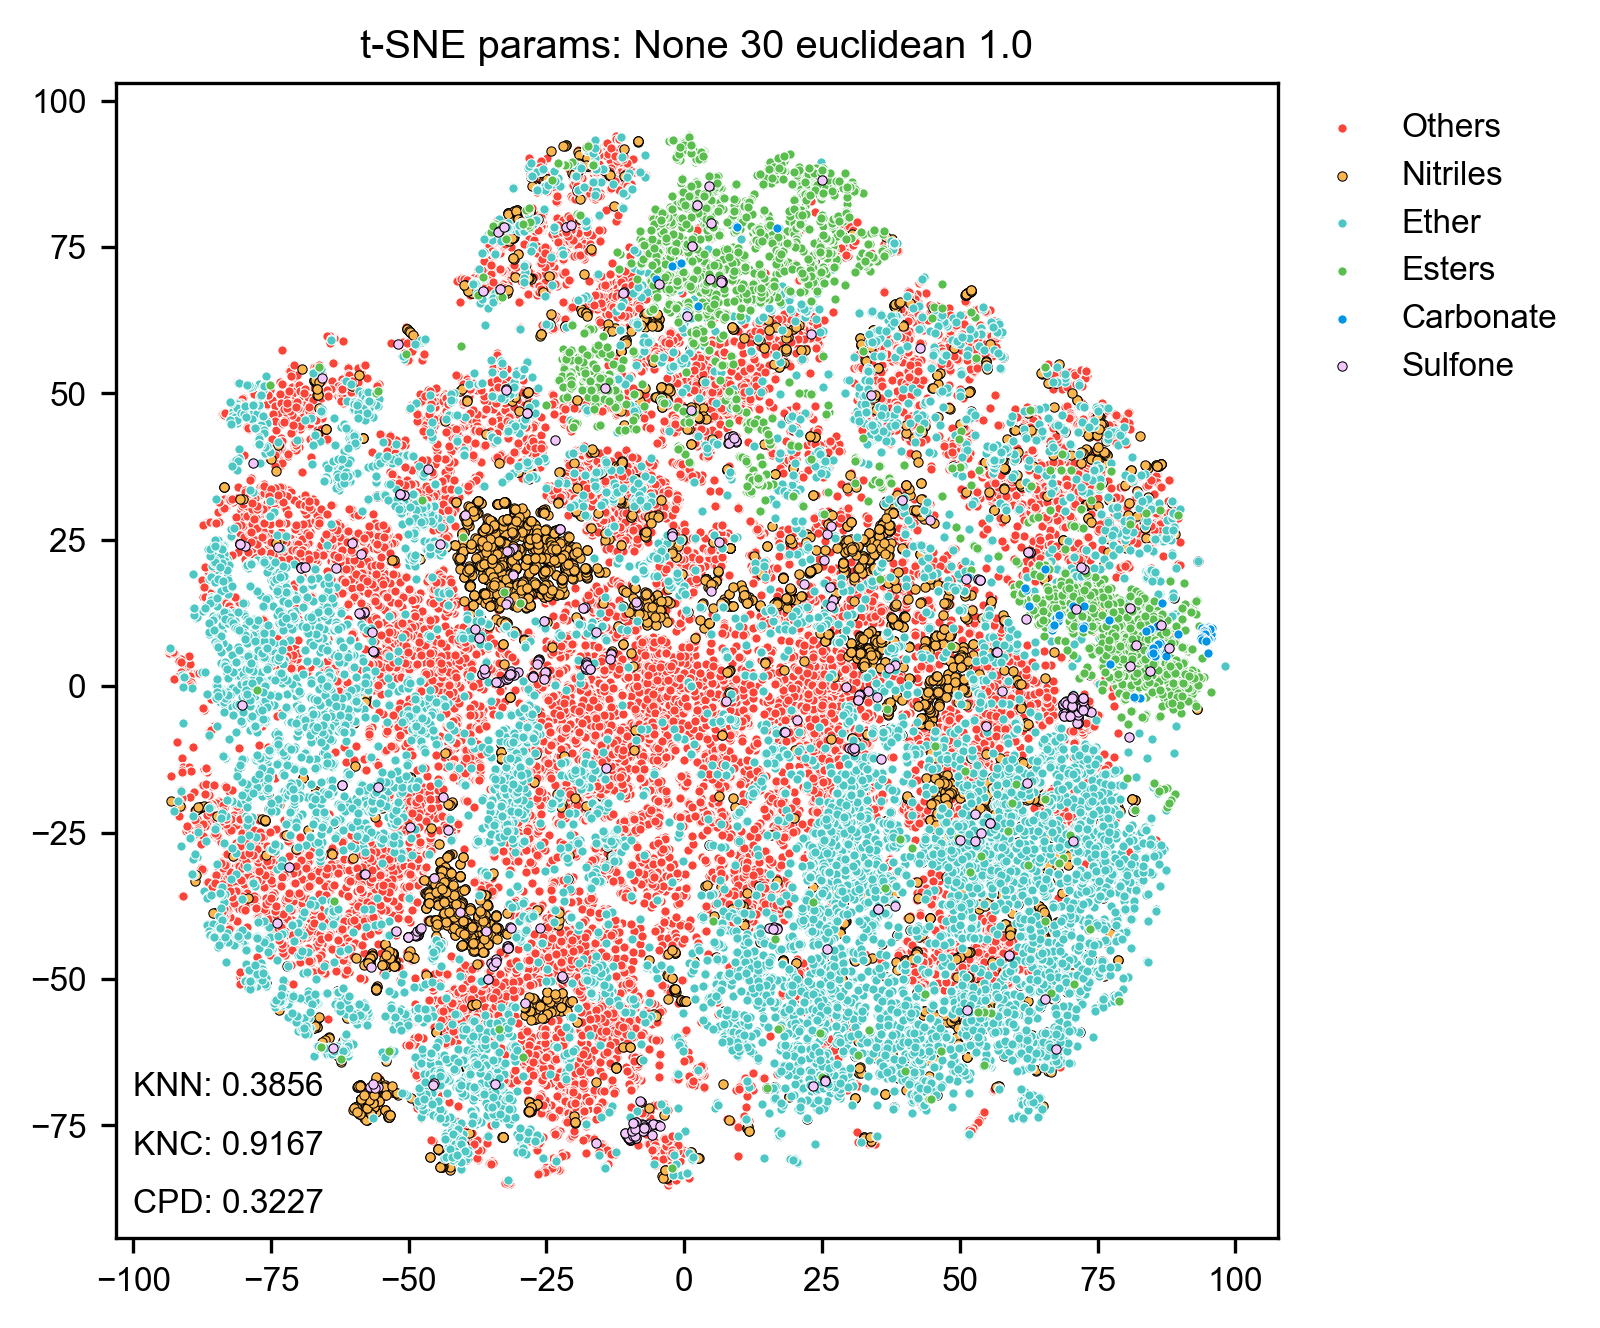

In [25]:
## default t-SNE
# trial = 3
X_tsne = pd.read_csv('tsne_default_openTSNE.csv')
df['tsne_0'] = X_tsne['tsne_0']
df['tsne_1'] = X_tsne['tsne_1']
fig, ax = plt.subplots(figsize=(5, 5))
df_hyper_default_tsne_open = pd.read_csv('param_tsne_default_openTSNE.csv')
# plt.title("t-SNE params: {} {} {} {}".format(df_hyper_default_tsne_open[['random_state', 'perplexity', 'metric', 'exaggeration']].iloc[0].values))
plt.title("t-SNE params: {} {} {} {}".format('None', 30, 'euclidean', 1.0))
classes = ['Others', 'Nitriles', 'Ether', 'Esters', 'Carbonate', 'Sulfone']
colors = [(0.984, 0.262, 0.219), (0.984, 0.713, 0.305), (0.298, 0.78, 0.77), (0.349,0.745,0.306), (0, 0.576, 0.902), (0.95, 0.78, 0.996)]
# colors.reverse()
edge_color = ['white', 'black', 'white', 'white', 'white', 'black']
i=0
for cls in classes:
    df_cls = df.loc[df['class'] == cls]
    ax.scatter(df_cls['tsne_0'], df_cls['tsne_1'], label=cls, alpha=1.0, color=colors[i], edgecolor=edge_color[i], linewidth=0.25, s=5)
    i += 1
plt.text(-100, -70, 'KNN: {:.4f}'.format(df_hyper_default_tsne_open['knn'][0]), family='Arial', size=8, color='black')
plt.text(-100, -80, 'KNC: {:.4f}'.format(df_hyper_default_tsne_open['knc'][0]), family='Arial', size=8, color='black')
plt.text(-100, -90, 'CPD: {:.4f}'.format(df_hyper_default_tsne_open['cpd'][0]), family='Arial', size=8, color='black')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', frameon=False)
plt.savefig('tsne_fig4c_trial_default_open.tiff', dpi=300, bbox_inches='tight')

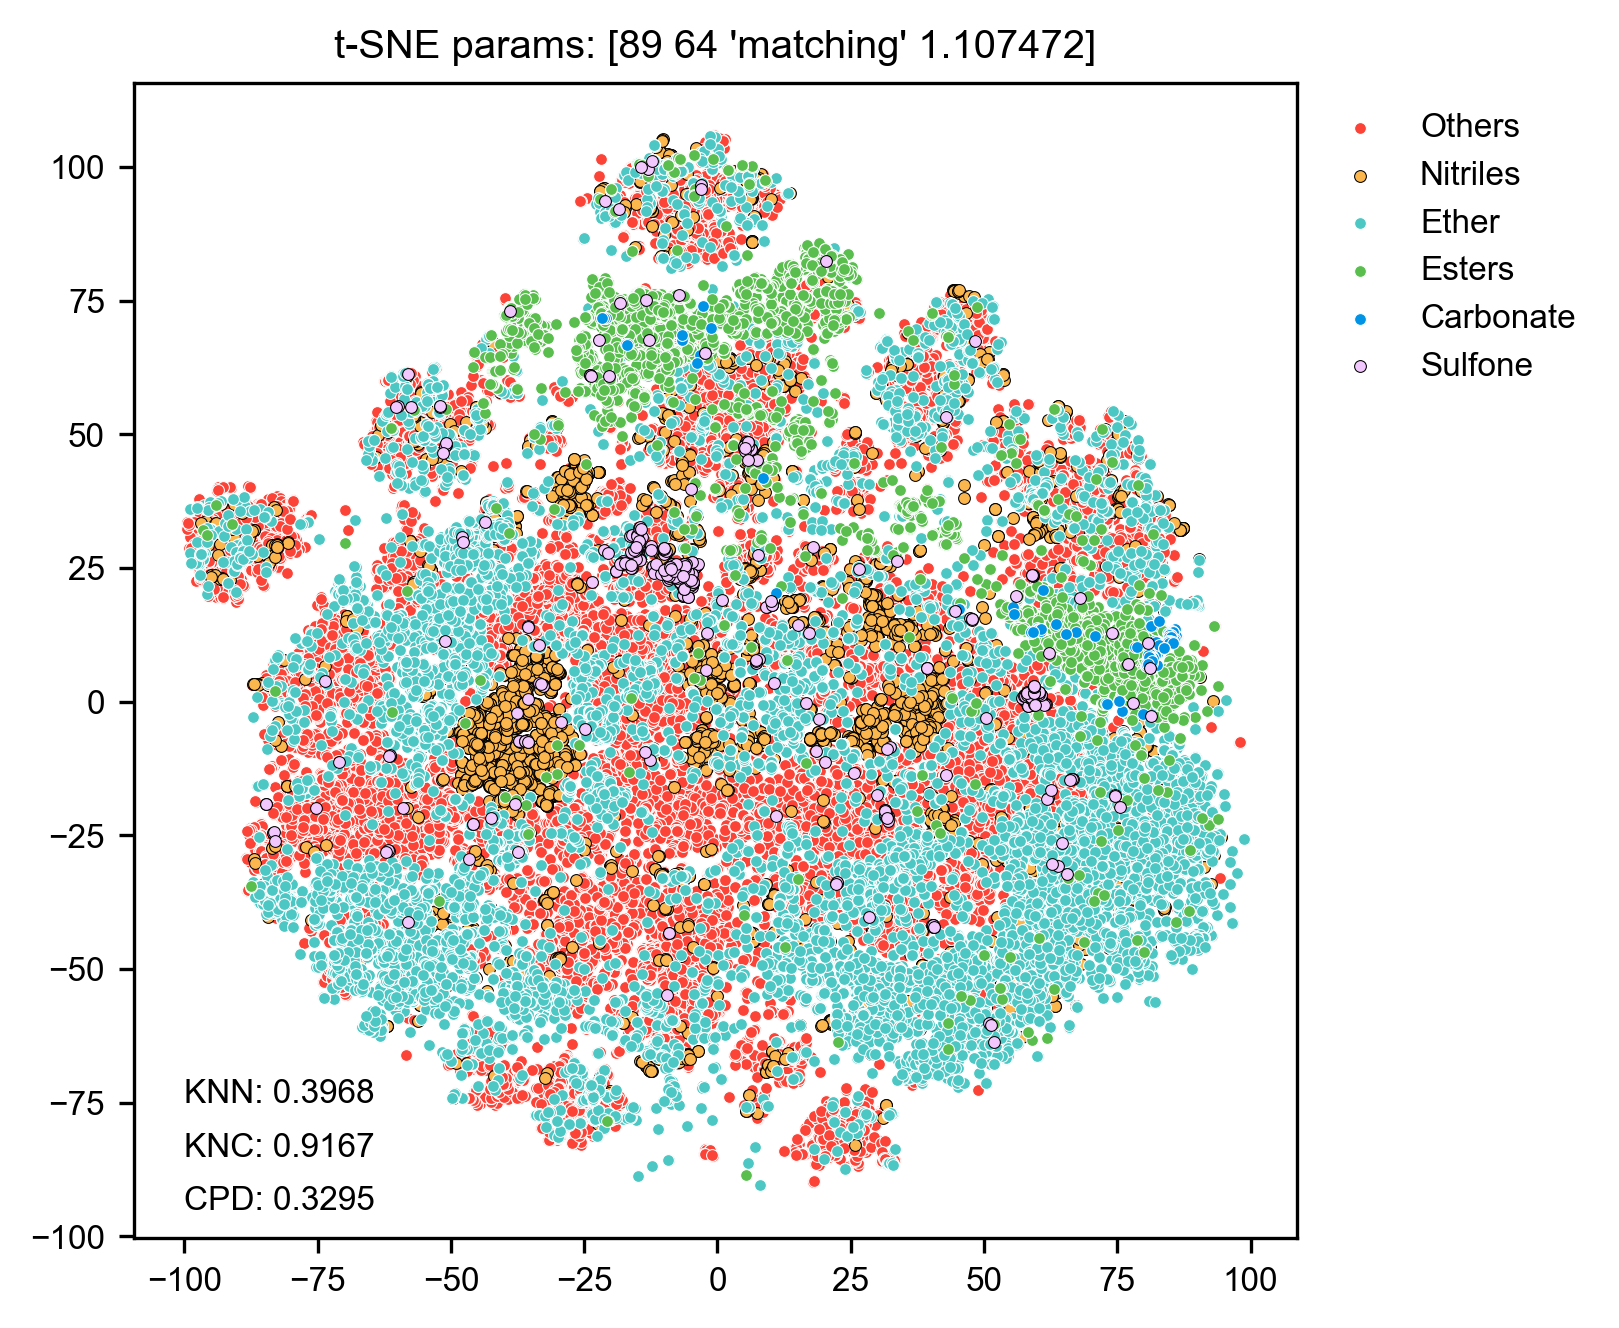

In [127]:
# trial = 3 -- not using
# X_tsne = np.load('./X_tsne_trial_{}_openTSNE.npy'.format(trial), allow_pickle=True)
# df['tsne_0'] = X_tsne[:,0]
# df['tsne_1'] = X_tsne[:,1]
# fig, ax = plt.subplots(figsize=(5, 5))
# plt.title("t-SNE params: {}".format(df_hyper_tsne_open[['random_state', 'perplexity', 'metric', 'exaggeration']].iloc[trial].values))
# classes = ['Others', 'Nitriles', 'Ether', 'Esters', 'Carbonate', 'Sulfone']
# colors = [(0.984, 0.262, 0.219), (0.984, 0.713, 0.305), (0.298, 0.78, 0.77), (0.349,0.745,0.306), (0, 0.576, 0.902), (0.95, 0.78, 0.996)]
# # colors.reverse()
# edge_color = ['white', 'black', 'white', 'white', 'white', 'black']
# i=0
# for cls in classes:
#     df_cls = df.loc[df['class'] == cls]
#     ax.scatter(df_cls['tsne_0'], df_cls['tsne_1'], label=cls, alpha=1.0, color=colors[i], edgecolor=edge_color[i], linewidth=0.25, s=8)
#     i += 1
# plt.text(-100, -75, 'KNN: {:.4f}'.format(df_hyper_tsne_open['knn'][trial]), family='Arial', size=8, color='black')
# plt.text(-100, -85, 'KNC: {:.4f}'.format(df_hyper_tsne_open['knc'][trial]), family='Arial', size=8, color='black')
# plt.text(-100, -95, 'CPD: {:.4f}'.format(df_hyper_tsne_open['cpd'][trial]), family='Arial', size=8, color='black')
# plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', frameon=False)
# plt.savefig('tsne_fig4c_trial_{}_open.tiff'.format(trial), dpi=300, bbox_inches='tight')

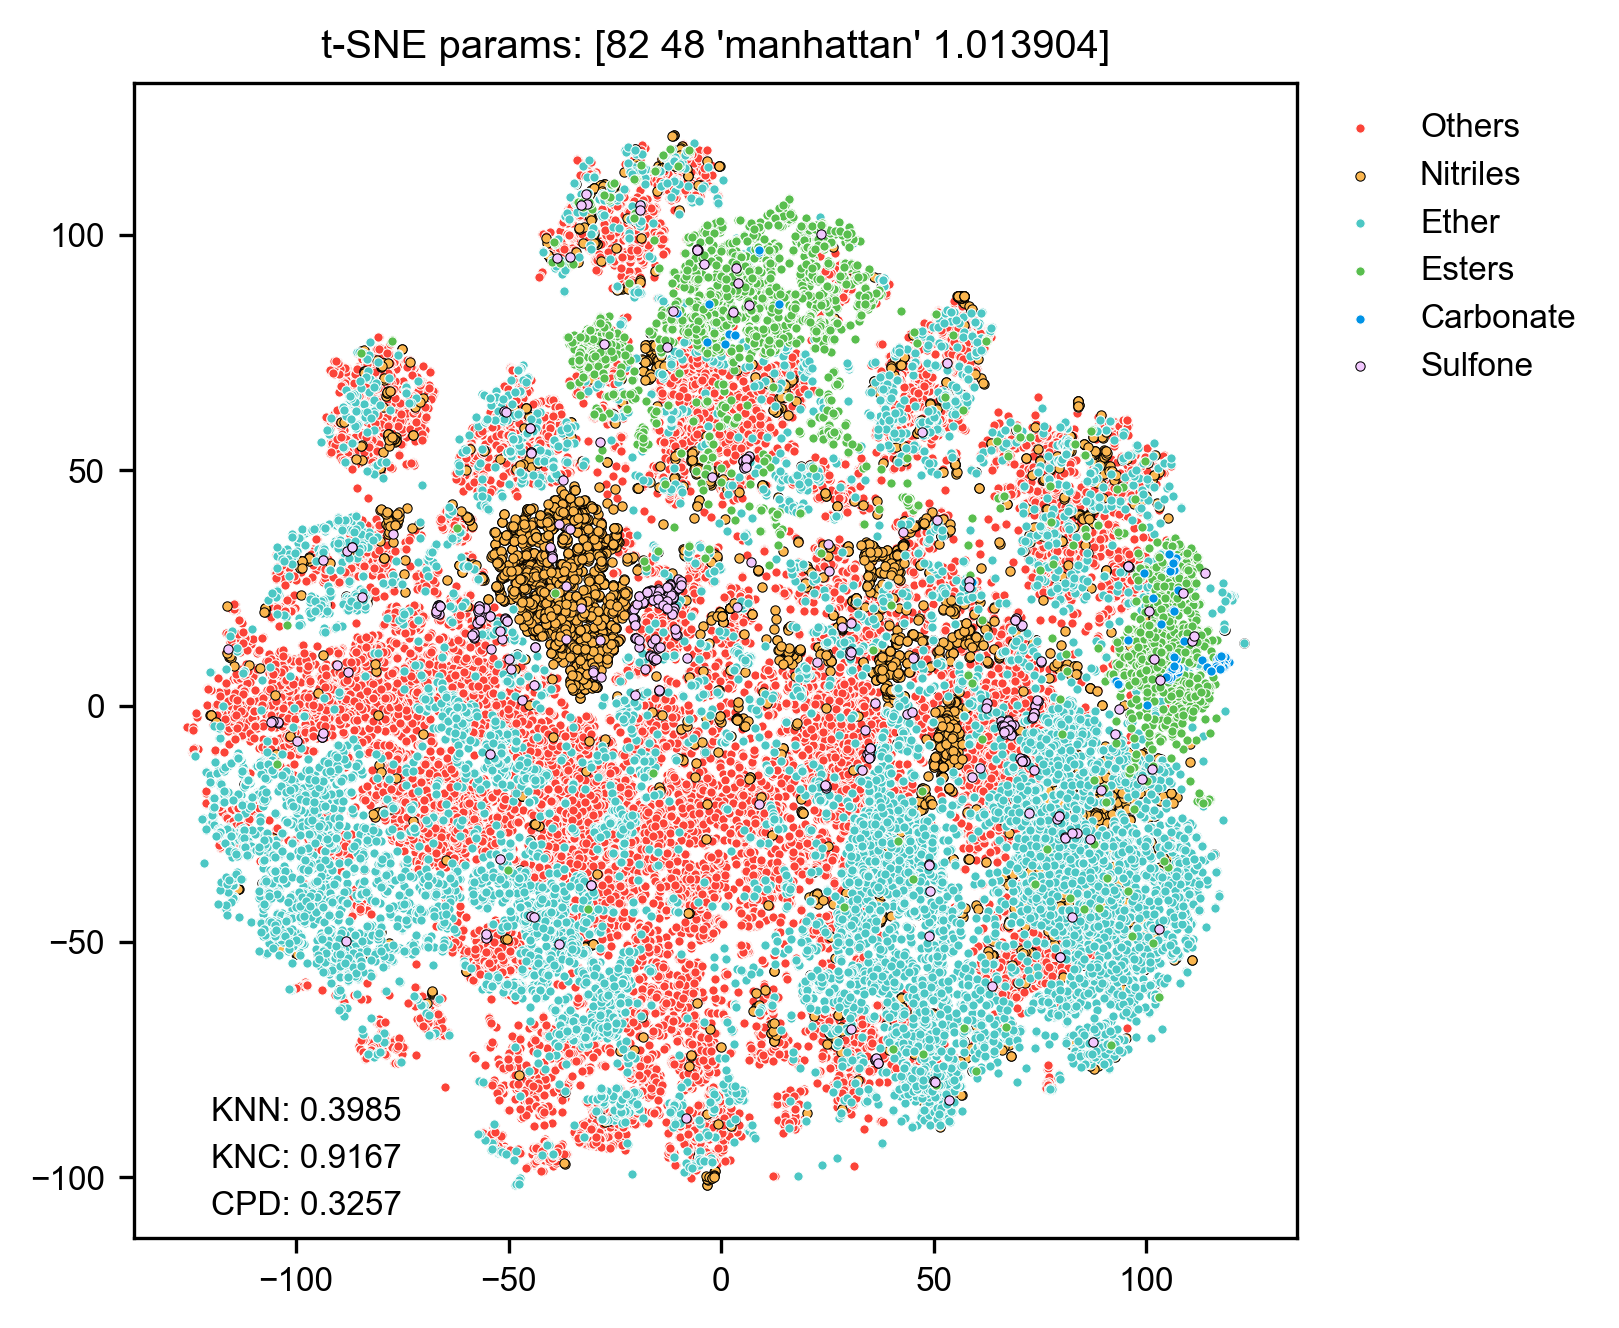

In [27]:
trial = 24
X_tsne = np.load('./X_tsne_trial_{}_openTSNE.npy'.format(trial), allow_pickle=True)
df['tsne_0'] = X_tsne[:,0]
df['tsne_1'] = X_tsne[:,1]
fig, ax = plt.subplots(figsize=(5, 5))
plt.title("t-SNE params: {}".format(df_hyper_tsne_open[['random_state', 'perplexity', 'metric', 'exaggeration']].iloc[trial].values))
classes = ['Others', 'Nitriles', 'Ether', 'Esters', 'Carbonate', 'Sulfone']
# colors = [(0, 0.576, 0.902), (0.298, 0.78, 0.77), (0.984, 0.713, 0.305), (0.349,0.745,0.306), (0.95, 0.78, 0.996), (0.984, 0.262, 0.219), (0.557, 0, 0.998)]
colors = [(0.984, 0.262, 0.219), (0.984, 0.713, 0.305), (0.298, 0.78, 0.77), (0.349,0.745,0.306), (0, 0.576, 0.902), (0.95, 0.78, 0.996)]
# colors.reverse()
# edge_color = ['black', 'white', 'gray', 'white', 'black', 'gray', 'white']
edge_color = ['white', 'black', 'white', 'white', 'white', 'black', 'black']
i=0
for cls in classes:
    df_cls = df.loc[df['class'] == cls]
    ax.scatter(df_cls['tsne_0'], df_cls['tsne_1'], label=cls, alpha=1.0, color=colors[i], edgecolor=edge_color[i], linewidth=0.25, s=5)
    i += 1
plt.text(-120, -88, 'KNN: {:.4f}'.format(df_hyper_tsne_open['knn'][trial]), family='Arial', size=8, color='black')
plt.text(-120, -98, 'KNC: {:.4f}'.format(df_hyper_tsne_open['knc'][trial]), family='Arial', size=8, color='black')
plt.text(-120, -108, 'CPD: {:.4f}'.format(df_hyper_tsne_open['cpd'][trial]), family='Arial', size=8, color='black')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', frameon=False)
plt.savefig('tsne_fig4c_trial_{}_open.tiff'.format(trial), dpi=300, bbox_inches='tight')

**Plot eScores**

In [2]:
def create_cmap(listval, color):
    vmin = min(listval)
    vmax = max(listval)
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    cmap = mcolors.LinearSegmentedColormap.from_list('', [(norm(vmin), 'white'), (norm(vmax), color)])
    return cmap, norm

def create_cmap_log(listval, color):
    vmin = min(listval)
    vmax = max(listval)
    norm = mcolors.LogNorm(vmin=vmin, vmax=vmax)
    cmap = mcolors.LinearSegmentedColormap.from_list('', [(norm(vmin), 'white'), (norm(vmax), color)])
    return cmap, norm

In [6]:
trial = 24
X_tsne = np.load('./X_tsne_trial_{}_openTSNE.npy'.format(trial), allow_pickle=True)
df['tsne_0'] = X_tsne[:,0]
df['tsne_1'] = X_tsne[:,1]
df

solv_comb_sm     score    database     class     tsne_0  \
0                      N#CC(F)Cl  0.640642  emolecules  Nitriles -40.520080   
1                     CC(C#N)C#N  0.637202  emolecules  Nitriles -39.789117   
2                     COC(=O)C#N  0.632583  emolecules    Esters  -3.742554   
3                       N#CC(F)F  0.631385  emolecules  Nitriles -40.468889   
4               CC(=O)OC(C#N)C#N  0.625274  emolecules    Esters -12.921387   
...                          ...       ...         ...       ...        ...   
62547       CS(=O)(=O)OCC(F)(F)F  0.991400       known    Others -24.342435   
62548            FC(F)(F)C1COCO1  0.985000       known     Ether  47.847478   
62549  FC(F)(F)COCCOCCOCC(F)(F)F  0.991411       known     Ether -47.611665   
62550                    FCCOCCF  0.997000       known     Ether -21.717168   
62551              FCCOCCOCCOCCF  0.874748       known     Ether -21.758317   

          tsne_1  
0      26.269161  
1      24.924783  
2      49.067006  
3      26.255678  
4      76.461929  
...          ...  
62547   5.672320  
62548 -27.333889  
62549 -36.590871  
62550 -52.049601  
62551 -52.072518  

[62552 rows x 6 columns]

In [30]:
df['database'].unique()

array(['emolecules', 'pubchem', 'gdb17', 'known'], dtype=object)

In [7]:
emol = df.loc[df['database'] == 'emolecules']
pub = df.loc[df['database'] == 'pubchem']
gdb = df.loc[df['database'] == 'gdb17']
known = df.loc[df['database'] == 'known']

In [8]:
smiles = ['CCN1CCOCC1', 'COC(=O)C#N', 'CCS(=O)(=O)F', 'CCOCCS(=O)(=O)F', 'COCCOC', 'COCC(F)(F)C(F)(F)COC', 'FC(F)(F)COCCOCCOCC(F)(F)F']
std_smiles = [Chem.MolToSmiles(Chem.MolFromSmiles(sm)) for sm in smiles]

In [37]:
# df.loc[df['solv_comb_sm'] == 'CCN1CCOCC1']['score'] = 1e-6 ## assign a score of 1e-6 to the EM
# df.loc[df['solv_comb_sm'] == 'CCN1CCOCC1', 'score'] = 0.0 ## assign a score of 1e-3 to the EM
# df.loc[df['solv_comb_sm'] == 'CCN1CCOCC1']
# df.loc[df['solv_comb_sm'] == std_smiles[3]]
# df.loc[df['solv_comb_sm'] == std_smiles[6]]
# df.loc[df['solv_comb_sm'] == std_smiles[5]]
# df.loc[df['solv_comb_sm'] == std_smiles[4]]
# df.loc[df['solv_comb_sm'] == std_smiles[3]]
df.loc[df['solv_comb_sm'].isin(std_smiles)]

solv_comb_sm     score    database   class     tsne_0  \
2                     COC(=O)C#N  0.632583  emolecules  Esters  -3.742554   
226                 CCS(=O)(=O)F  0.569395  emolecules  Others -15.842240   
783              CCOCCS(=O)(=O)F  0.549244  emolecules   Ether -47.517316   
4636                  CCN1CCOCC1  0.000000  emolecules   Ether   3.175537   
22431       COCC(F)(F)C(F)(F)COC  0.519434     pubchem   Ether -42.079246   
62504       COCC(F)(F)C(F)(F)COC  0.994733       known   Ether -42.084319   
62507                     COCCOC  0.944793       known   Ether -23.448222   
62549  FC(F)(F)COCCOCCOCC(F)(F)F  0.991411       known   Ether -47.611665   

          tsne_1  
2      49.067006  
226    14.373581  
783   -27.755104  
4636  -63.210487  
22431 -40.933395  
62504 -40.936859  
62507 -58.768368  
62549 -36.590871

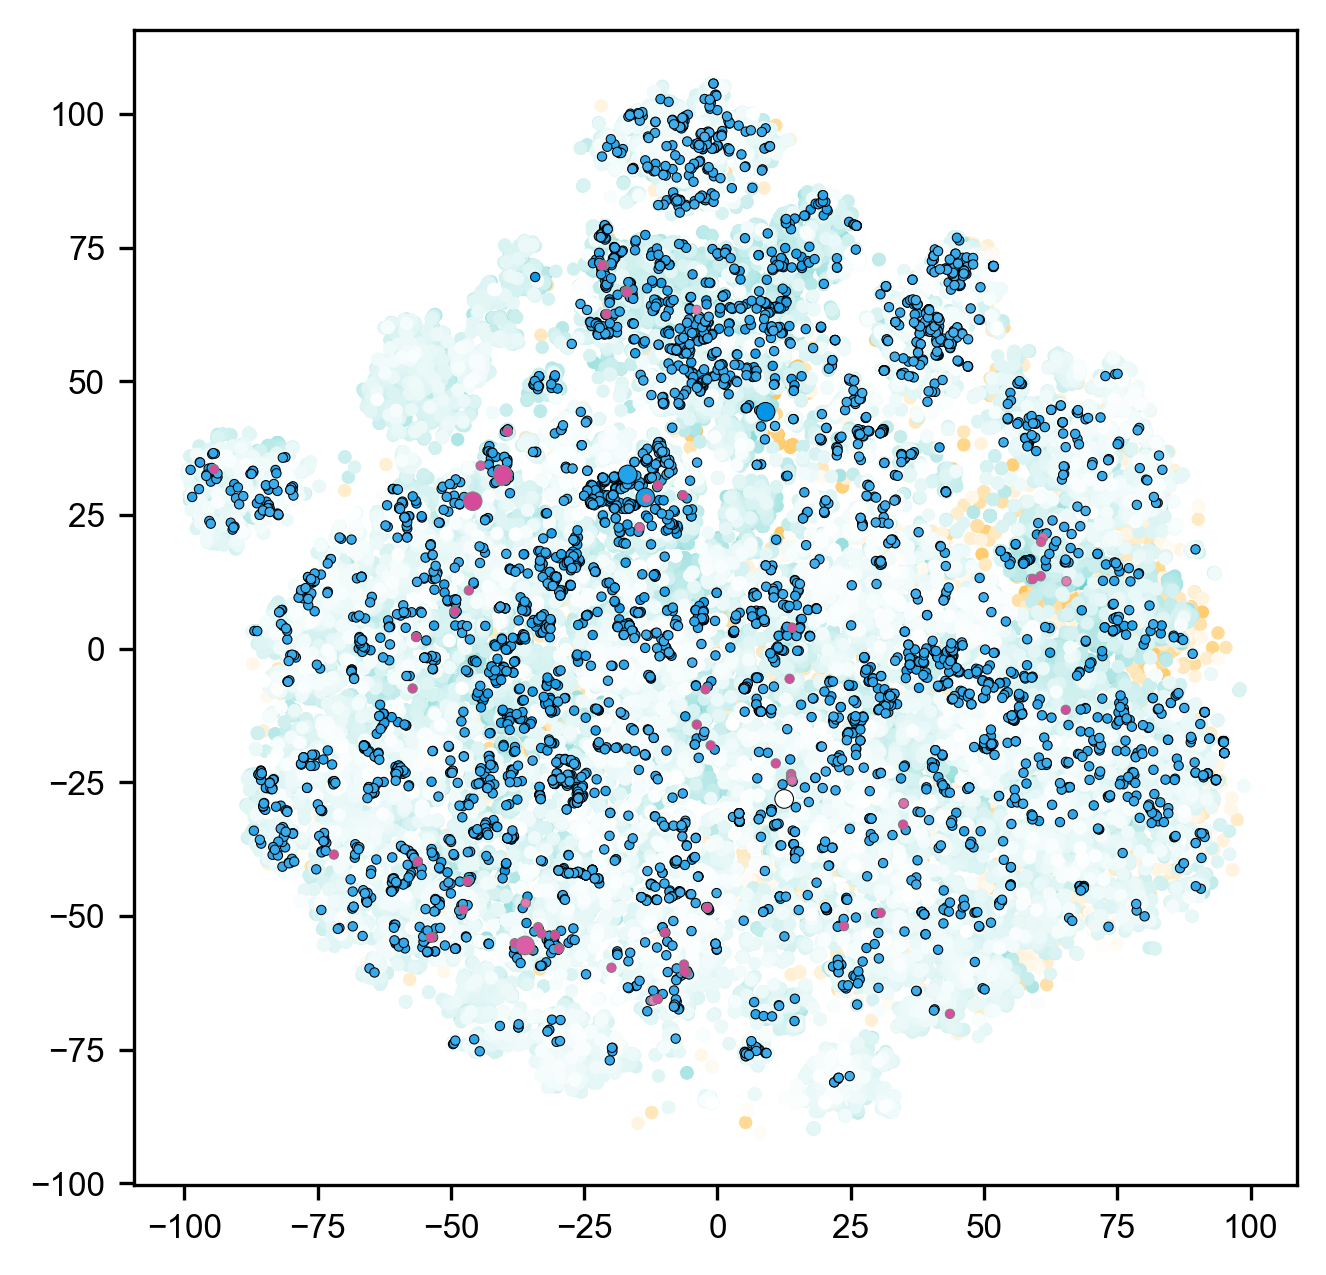

In [105]:
# ## for trial = 3 -- not using this since DME and fluorinated ethers are further apart
# fig, ax = plt.subplots(figsize=(5,5))
# cmap1, norm1 = create_cmap(gdb["score"], "orange")  ## orange colormap
# cmap2, norm2 = create_cmap(pub["score"], (0.298, 0.78, 0.77))  ## anvil colormap
# cmap3, norm3 = create_cmap(emol["score"], (0, 0.576, 0.902))  ## blue colormap -- normal scale
# # cmap3, norm3 = create_cmap_log(emol["score"], (0, 0.576, 0.902))  ## blue colormap -- log scale
# cmap4, norm4 = create_cmap(known["score"], (0.839, 0.286, 0.604))  ## purple colormap

# highlight_coords_1 = [tuple(row) for row in df.loc[df['solv_comb_sm'].isin(std_smiles[:4])][['tsne_0', 'tsne_1']].values]
# highlight_coords_2 = [tuple(row) for row in df.loc[df['solv_comb_sm'].isin(std_smiles[4:])][['tsne_0', 'tsne_1']].values]

# scatter1 = ax.scatter(gdb["tsne_0"], gdb["tsne_1"], c=gdb["score"], s=5, cmap=cmap1, norm=norm1, label='GDB-17', edgecolors=None)
# scatter2 = ax.scatter(pub["tsne_0"], pub["tsne_1"], c=pub["score"], s=5, cmap=cmap2, norm=norm2, label='PubChem', edgecolors=None)

# mask1_1 = ~emol[['tsne_0', 'tsne_1']].apply(tuple, axis=1).isin(highlight_coords_1)
# scatter3_1 = ax.scatter(emol[mask1_1]["tsne_0"], emol[mask1_1]["tsne_1"], c=emol[mask1_1]["score"], s=5, cmap=cmap3, norm=norm3, label='eMolecules', edgecolors='black', linewidths=0.25)
# mask1_2 = emol[['tsne_0', 'tsne_1']].apply(tuple, axis=1).isin(highlight_coords_1)
# scatter3_2 = ax.scatter(emol[mask1_2]["tsne_0"], emol[mask1_2]["tsne_1"], c=emol[mask1_2]["score"], s=20, cmap=cmap3, norm=norm3, label='eMolecules', edgecolors='black', linewidths=0.25)

# mask2_1 = ~known[['tsne_0', 'tsne_1']].apply(tuple, axis=1).isin(highlight_coords_2)
# scatter4_1 = ax.scatter(known[mask2_1]["tsne_0"], known[mask2_1]["tsne_1"], c=known[mask2_1]["score"], s=5, cmap=cmap4, norm=norm4, label='EDB-CE', edgecolors='gray', linewidths=0.25)
# mask2_2 = known[['tsne_0', 'tsne_1']].apply(tuple, axis=1).isin(highlight_coords_2)
# scatter4_2 = ax.scatter(known[mask2_2]["tsne_0"], known[mask2_2]["tsne_1"], c=known[mask2_2]["score"], s=20, cmap=cmap4, norm=norm4, label='EDB-CE', edgecolors='gray', linewidths=0.25)
# # scatter3 = ax.scatter(emol["tsne_0"], emol["tsne_1"], c=emol["score"], s=6, cmap=cmap3, norm=norm3, label='eMolecules', edgecolors='black', linewidths=0.25)
# # scatter4 = ax.scatter(known["tsne_0"], known["tsne_1"], c=known["score"], s=6, cmap=cmap4, norm=norm4, label='EDB-CE', edgecolors='gray', linewidths=0.25)
# # ax.vlines(x=[-5,0,5,10], ymin=-60, ymax=60, linestyles='dashed', colors='black')
# # ax.hlines(y=[20,30,50], xmin=-60, xmax=60, linestyles='dashed', colors='black')
# # scatter2 = ax.scatter(edb_cond["TNSE_0"], edb_cond["TNSE_1"], c=edb_cond["mean_prop"], s=15, cmap=cmap2, norm=norm2, label='EDB-$\sigma$', edgecolors='black')
# # plt.xlim([-10,50])
# # plt.ylim([-10,50])
# # fig.colorbar(scatter1, ax=ax, ticks=[0.47, 0.50, 0.53, 0.56])
# # fig.colorbar(scatter2, ax=ax, ticks=[0.49, 0.52, 0.55, 0.58])
# # fig.colorbar(scatter3, ax=ax, ticks=[0.20, 0.40, 0.60])
# # fig.colorbar(scatter4, ax=ax, ticks=[0.6, 0.7, 0.8, 0.9, 0.97])
# # plt.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
#                 # mode="expand", borderaxespad=0, ncol=3)
# # plt.annotate(req_solv['solv_comb_sm'][0], xy=(req_solv['TNSE_0'][0], req_solv['TNSE_1'][0]), color='green', fontsize=10)
# # plt.annotate('0', xy=(req_solv['TNSE_0'][0], req_solv['TNSE_1'][0]), color='green', fontsize=12)
# # plt.annotate('1', xy=(req_solv['TNSE_0'][1], req_solv['TNSE_1'][1]), color='green', fontsize=12)
# # plt.annotate('2', xy=(req_solv['TNSE_0'][2], req_solv['TNSE_1'][2]), color='green', fontsize=12)
# # plt.annotate('3', xy=(req_solv['TNSE_0'][3], req_solv['TNSE_1'][3]), color='green', fontsize=12)
# # plt.annotate('4', xy=(req_solv['TNSE_0'][4], req_solv['TNSE_1'][4]), color='black', fontsize=12)
# # plt.annotate('5', xy=(req_solv['TNSE_0'][5], req_solv['TNSE_1'][5]), color='black', fontsize=12)
# # plt.annotate('6', xy=(req_solv['TNSE_0'][6], req_solv['TNSE_1'][6]), color='black', fontsize=12)
# # ax.set_aspect(aspect=1.0)
# # plt.savefig('tsne_mean_threeRep_new_052623.eps', dpi=300, bbox_inches='tight')

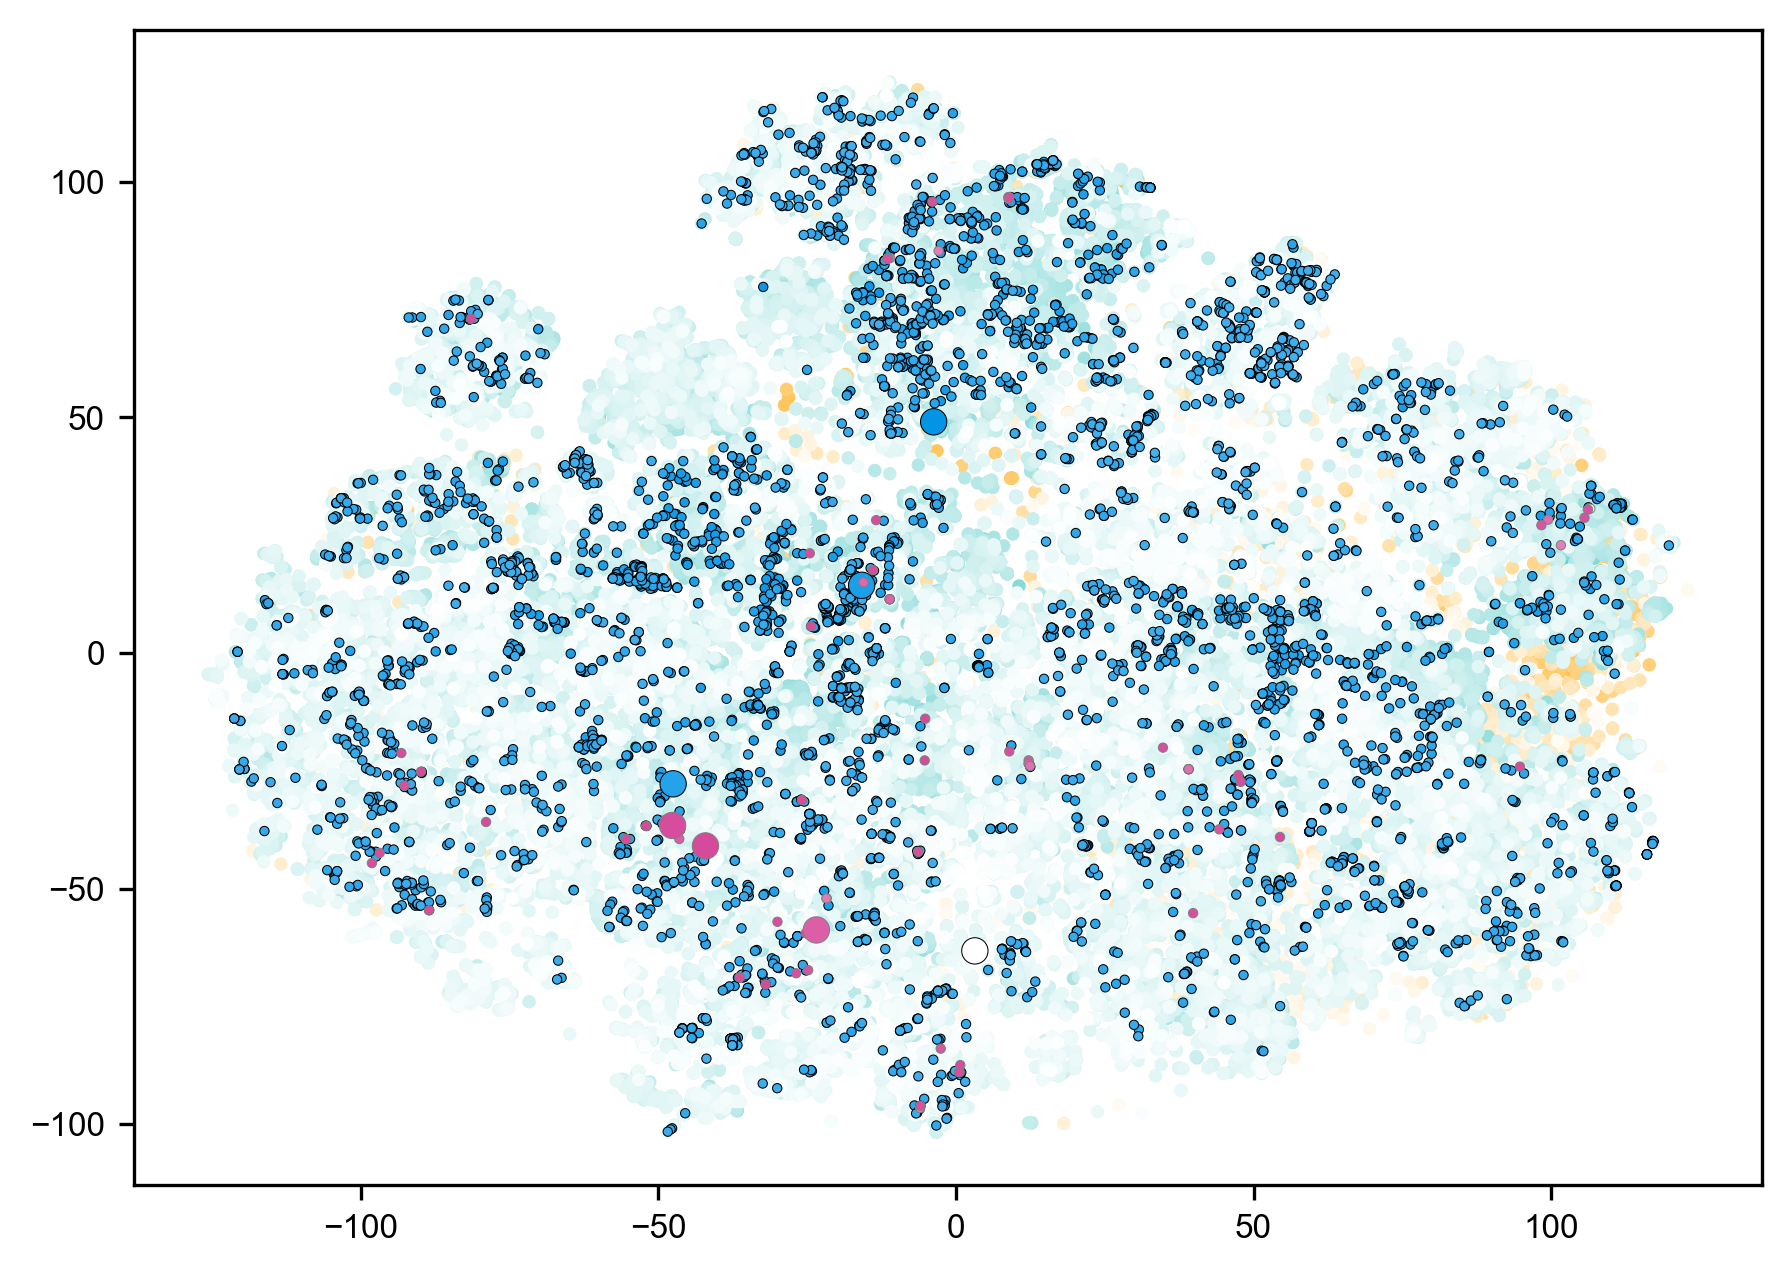

In [10]:
## for trial = 24
fig, ax = plt.subplots(figsize=(7,5))
cmap1, norm1 = create_cmap(gdb["score"], "orange")  ## orange colormap
cmap2, norm2 = create_cmap(pub["score"], (0.298, 0.78, 0.77))  ## anvil colormap
cmap3, norm3 = create_cmap(emol["score"], (0, 0.576, 0.902))  ## blue colormap -- normal scale
# cmap3, norm3 = create_cmap_log(emol["score"], (0, 0.576, 0.902))  ## blue colormap -- log scale
cmap4, norm4 = create_cmap(known["score"], (0.839, 0.286, 0.604))  ## purple colormap

highlight_coords_1 = [tuple(row) for row in df.loc[df['solv_comb_sm'].isin(std_smiles[:4])][['tsne_0', 'tsne_1']].values]
highlight_coords_2 = [tuple(row) for row in df.loc[df['solv_comb_sm'].isin(std_smiles[4:])][['tsne_0', 'tsne_1']].values]

scatter1 = ax.scatter(gdb["tsne_0"], gdb["tsne_1"], c=gdb["score"], s=5, cmap=cmap1, norm=norm1, label='GDB-17', edgecolors=None)
scatter2 = ax.scatter(pub["tsne_0"], pub["tsne_1"], c=pub["score"], s=5, cmap=cmap2, norm=norm2, label='PubChem', edgecolors=None)

mask1_1 = ~emol[['tsne_0', 'tsne_1']].apply(tuple, axis=1).isin(highlight_coords_1)
scatter3_1 = ax.scatter(emol[mask1_1]["tsne_0"], emol[mask1_1]["tsne_1"], c=emol[mask1_1]["score"], s=5, cmap=cmap3, norm=norm3, label='eMolecules', edgecolors='black', linewidths=0.25)
mask1_2 = emol[['tsne_0', 'tsne_1']].apply(tuple, axis=1).isin(highlight_coords_1)
scatter3_2 = ax.scatter(emol[mask1_2]["tsne_0"], emol[mask1_2]["tsne_1"], c=emol[mask1_2]["score"], s=40, cmap=cmap3, norm=norm3, label='eMolecules', edgecolors='black', linewidths=0.25)

mask2_1 = ~known[['tsne_0', 'tsne_1']].apply(tuple, axis=1).isin(highlight_coords_2)
scatter4_1 = ax.scatter(known[mask2_1]["tsne_0"], known[mask2_1]["tsne_1"], c=known[mask2_1]["score"], s=5, cmap=cmap4, norm=norm4, label='EDB-CE', edgecolors='gray', linewidths=0.25)
mask2_2 = known[['tsne_0', 'tsne_1']].apply(tuple, axis=1).isin(highlight_coords_2)
scatter4_2 = ax.scatter(known[mask2_2]["tsne_0"], known[mask2_2]["tsne_1"], c=known[mask2_2]["score"], s=40, cmap=cmap4, norm=norm4, label='EDB-CE', edgecolors='gray', linewidths=0.25)
# scatter3 = ax.scatter(emol["tsne_0"], emol["tsne_1"], c=emol["score"], s=6, cmap=cmap3, norm=norm3, label='eMolecules', edgecolors='black', linewidths=0.25)
# scatter4 = ax.scatter(known["tsne_0"], known["tsne_1"], c=known["score"], s=6, cmap=cmap4, norm=norm4, label='EDB-CE', edgecolors='gray', linewidths=0.25)
# scatter2 = ax.scatter(edb_cond["TNSE_0"], edb_cond["TNSE_1"], c=edb_cond["mean_prop"], s=15, cmap=cmap2, norm=norm2, label='EDB-$\sigma$', edgecolors='black')
# plt.xlim([-10,50])
# plt.ylim([-10,50])
# fig.colorbar(scatter1, ax=ax, ticks=[0.44, 0.50, 0.56, 0.62])
# fig.colorbar(scatter2, ax=ax, ticks=[0.50, 0.55, 0.60, 0.65])
# fig.colorbar(scatter3_1, ax=ax, ticks=[0.00, 0.20, 0.40, 0.60])
# fig.colorbar(scatter4_1, ax=ax, ticks=[0.6, 0.7, 0.8, 0.9, 0.99])

plt.savefig('tsne_fig4c_022424.tiff', dpi=300, bbox_inches='tight')
# plt.savefig('tsne_fig4c.eps', dpi=300, bbox_inches='tight')

**Save tSNE as HTML files (tSNE using openTSNE)**

In [120]:
df['class'].value_counts()

class
Others       33577
Ether        18551
Nitriles      5121
Esters        4709
Sulfone        434
Carbonate      160
Name: count, dtype: int64

In [124]:
def _prepareMol(mol,kekulize):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    return mc

def moltosvg(mol,molSize=(250,100),kekulize=True,drawer=None,**kwargs):
    mc = _prepareMol(mol,kekulize)
    if drawer is None:
        drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc,**kwargs)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return SVG(svg.replace('svg:',''))

PandasTools.AddMoleculeColumnToFrame(df,'solv_comb_sm', 'solv')

svgs_solv = [moltosvg(m).data for m in df.solv]
smile = df['solv_comb_sm'].values.tolist()
database_class = df['class'].values.tolist()
database = df['database'].values.tolist()
ind = df.index.values.tolist()
ChangeMoleculeRendering(renderer='PNG')

## provided by copilot
def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % (int(rgb[0]*255), int(rgb[1]*255), int(rgb[2]*255))

# color_dict = {'Others':(0.984, 0.262, 0.219), 'Ether':(0.298, 0.78, 0.77),
#               'Nitriles':(0.984, 0.713, 0.305), 'Esters':(0.349,0.745,0.306), 'Carbonate':(0, 0.576, 0.902), 
#               'Sulfone':(0.95, 0.78, 0.996)}

color_dict = {'emolecules': (0, 0.576, 0.902), 'pubchem': (0.298, 0.78, 0.77), 'gdb17': (0.984, 0.713, 0.305), 'known': (0.839, 0.286, 0.604)}
color_dict_hex = {k: rgb_to_hex(v) for k, v in color_dict.items()}

# source = ColumnDataSource(data=dict(x=df['TSNE_0'], y=df['TSNE_1'], svgs_solv=svgs_solv, desc=database_class, smile=smile, ind=ind, color=df['class'].map(color_dict_hex)))
source = ColumnDataSource(data=dict(x=df['tsne_0'], y=df['tsne_1'], svgs_solv=svgs_solv, desc=database_class, smile=smile, database=database, color=df['database'].map(color_dict_hex)))

hover = HoverTool(tooltips="""
    <div>
        <div> 
            <span style="font-size: 12px; font-weight: bold;"> @svgs_solv{safe} </span>
        </div>
        <div>
            <span style="font-size: 12px; font-weight: bold;"> SMILES: @smile </span>
        </div>
        <div>
            <span style="font-size: 12px; font-weight: bold;"> Class: @desc </span>
        </div>
        <div>
            <span style="font-size: 12px; font-weight: bold;"> Database: @database </span>
        </div>
    </div>
    """
)

interactive_map = figure(width=1000, height=1000, tools=['reset,box_zoom,wheel_zoom,zoom_in,zoom_out,pan',hover])
interactive_map.title.text = "Molecular visualizations of electrolyte solvent molecules (Figure 4(c))"
interactive_map.title.align = "center"
interactive_map.title.text_color = "orange"
interactive_map.title.text_font_size = "25px"

interactive_map.scatter('x', 'y', 
                        # color={'field': df_comb_tsne_['database'], 'transform': color_map},
                        color = 'color',
                        # legend='top_right', ## does not work
                        legend_field='database',
                        source=source, size=7, fill_alpha=0.8)
output_file("interactive_map_fig4c.html".format(trial))
save(interactive_map)

'/Users/riteshk/Library/CloudStorage/Box-Box/Research-postdoc/liquid-electrolyte-ML/Science-rev-1/red-dim-visualization/fig4-data/interactive_map_fig4c.html'

**Finding MCS**

In [33]:
# from rdkit import Chem
# from rdkit.Chem import rdFMCS
# from rdkit.Chem import Draw
# from rdkit.Chem.Draw import rdMolDraw2D
# from IPython.display import Image

# # Load molecules using SMILES strings
# # mol1 = Chem.MolFromSmiles('CCO')
# mol2 = Chem.MolFromSmiles('CCCOCCC') ## DPE
# # mol1 = Chem.MolFromSmiles('CCOCCOCC')
# # mol2 = Chem.MolFromSmiles('CCCO')
# mol1 = Chem.MolFromSmiles('COCCOC') ## DME

# # Find the maximum common substructure (MCS)
# mcs = rdFMCS.FindMCS([mol1, mol2])

# # Convert MCS result to an RDKit molecule
# mcs_mol = Chem.MolFromSmarts(mcs.smartsString)

# print(f"Common substructure: {Chem.MolToSmiles(mcs_mol)}")

Common substructure: CCOC


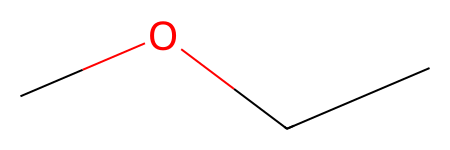

In [34]:
# mcs_mol

In [35]:
# ## do not use this

# # Find the atoms in mol2 that match the common substructure
# match_atoms = mol2.GetSubstructMatch(mcs_mol)

# # Draw mol2 with the common substructure highlighted
# img = Draw.MolToImage(mol2, highlightAtoms=match_atoms)
# img.show()

In [36]:
# # Find the atoms in mol2 that match the common substructure
# match_atoms = mol2.GetSubstructMatch(mcs_mol)

# # Find the bonds in mol2 that are between the matched atoms
# match_bonds = [mol2.GetBondBetweenAtoms(i, j).GetIdx() 
#                for i, j in zip(match_atoms[:-1], match_atoms[1:])]

# # Define colors for highlighting (in RGB format)
# color = (1, 0, 0)  # Red color
# color = blue

# # Create dictionaries that map atom and bond indices to colors
# highlight_atom_colors = {atom: color for atom in match_atoms}
# highlight_bond_colors = {bond: color for bond in match_bonds}

# # Create a drawer
# drawer = rdMolDraw2D.MolDraw2DSVG(400, 200)

# # Set the color of all bonds to black
# all_bond_colors = {bond.GetIdx(): (0, 0, 0) for bond in mol2.GetBonds()}  # Black color

# # Draw mol2 with the common substructure highlighted
# drawer.DrawMolecule(mol2, highlightAtoms=match_atoms, highlightBonds=match_bonds, 
#                     highlightAtomColors=highlight_atom_colors, highlightBondColors=highlight_bond_colors)
#                     # highlightAtomColors=highlight_atom_colors, highlightBondColors=all_bond_colors)

# # Set the atom label font to Arial
# drawer.drawOptions().atomLabelFontFace = 'Arial'
# # drawer.SetColour((0, 0, 0))

# drawer.FinishDrawing()
# svg = drawer.GetDrawingText().replace('svg:', '')
# SVG(svg)
# ## save the svg file
# with open('tt.svg', 'w') as f:
#     f.write(svg)